In [1]:
!pip install sentencepiece
!pip install transformers
!pip install datasets

In [2]:
import json
import os
from typing import Dict, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import mlx.optimizers as optim
from mlx.utils import tree_flatten
from mlx_lm import generate, load
from mlx_lm.tuner import TrainingArgs, datasets, linear_to_lora_layers, train
from transformers import PreTrainedTokenizer

In [3]:
import sentencepiece
model_path = "mlx-community/Mistral-7B-Instruct-v0.3-4bit"
#model_path = "mlx-community/Phi-3.5-mini-instruct-8bit"
model, tokenizer = load(model_path)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
prompt = "Express in SQL. What is background color of Australian capital territory?"

if tokenizer.chat_template is not None:
    messages = [{"role": "user", "content": prompt}]
    prompt = tokenizer.apply_chat_template(
        messages, add_generation_prompt=True
    )

response = generate(model, tokenizer, prompt=prompt, verbose=True)

SQL (Structured Query Language) is a programming language used for managing and manipulating relational databases. It does not have the capability to set or retrieve the background color of a geographical region like the Australian Capital Territory (ACT). SQL is used for database operations such as creating, updating, and querying data in a database. If you have data related to the ACT and want to retrieve it, you can use SQL for that purpose. For example, you can query for the population, area, or other attributes of the ACT. However, to set or retrieve the background color of a geographical region, you would need a different programming language or tool that can interact with a Graphics User Interface (GUI) or a mapping software.
Prompt: 18 tokens, 137.157 tokens-per-sec
Generation: 153 tokens, 55.126 tokens-per-sec
Peak memory: 4.158 GB


In [5]:
adapter_path = "adapters"
os.makedirs(adapter_path, exist_ok=True)
adapter_config_path = os.path.join(adapter_path, "adapter_config.json")
adapter_file_path = os.path.join(adapter_path, "adapters.safetensors")

In [6]:
lora_config = {
    "num_layers": 10,
    "lora_parameters": {
        "rank": 10,
        "scale": 20,
        "dropout": 0.4,
        "target_modules": [
        "self_attn.q_proj",
        "self_attn.v_proj",
#        "self_attn.k_proj",
#        "self_attn.o_proj"
    ],
    },
}

In [7]:
with open(adapter_config_path, "w") as f:
    json.dump(lora_config, f, indent=4)

In [8]:
training_args = TrainingArgs(
    adapter_file=adapter_file_path,
    iters=200,
    steps_per_eval=50,
    batch_size=4,
)

In [9]:
model.freeze()
linear_to_lora_layers(model, lora_config["num_layers"], lora_config["lora_parameters"])
num_train_params = sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
print(f"Number of trainable parameters: {num_train_params}")
model.train()

Number of trainable parameters: 1331200


Model(
  (model): LlamaModel(
    (embed_tokens): QuantizedEmbedding(32768, 4096, group_size=64, bits=4)
    (layers.0): TransformerBlock(
      (self_attn): Attention(
        (q_proj): QuantizedLinear(input_dims=4096, output_dims=4096, bias=False, group_size=64, bits=4)
        (k_proj): QuantizedLinear(input_dims=4096, output_dims=1024, bias=False, group_size=64, bits=4)
        (v_proj): QuantizedLinear(input_dims=4096, output_dims=1024, bias=False, group_size=64, bits=4)
        (o_proj): QuantizedLinear(input_dims=4096, output_dims=4096, bias=False, group_size=64, bits=4)
        (rope): RoPE(128, traditional=False)
      )
      (mlp): MLP(
        (gate_proj): QuantizedLinear(input_dims=4096, output_dims=14336, bias=False, group_size=64, bits=4)
        (down_proj): QuantizedLinear(input_dims=14336, output_dims=4096, bias=False, group_size=64, bits=4)
        (up_proj): QuantizedLinear(input_dims=4096, output_dims=14336, bias=False, group_size=64, bits=4)
      )
      (input_l

In [10]:
class Metrics:
    def __init__(self) -> None:
        self.train_losses: List[Tuple[int, float]] = []
        self.val_losses: List[Tuple[int, float]] = []

    def on_train_loss_report(self, info: Dict[str, Union[float, int]]) -> None:
        self.train_losses.append((info["iteration"], info["train_loss"]))

    def on_val_loss_report(self, info: Dict[str, Union[float, int]]) -> None:
        self.val_losses.append((info["iteration"], info["val_loss"]))

In [11]:
metrics = Metrics()

In [12]:
from datasets import load_dataset
def custom_load_hf_dataset(
    data_id: str,
    tokenizer: PreTrainedTokenizer,
    config: TrainingArgs = None,
    names: Tuple[str, str, str] = ("train", "valid", "test"),
):


    # Use default config if none provided
    if config is None:
        config = TrainingArgs()

    # Load the dataset from Hugging Face
    dataset = load_dataset(data_id)

    train, valid, test = [
        (
            datasets.create_dataset(dataset[n], tokenizer, config)
            if n in dataset.keys()
            else []
        )
            for n in names
    ]


    return train, valid, test

In [13]:
train_set, val_set, test_set = custom_load_hf_dataset(
    data_id="mlx-community/wikisql",
    tokenizer=tokenizer,
    names=("train", "valid", "test")
)

In [14]:
from mlx_lm.tuner.datasets import load_dataset, CacheDataset
train(
    model=model,
    args=training_args,
    optimizer=optim.AdamW(learning_rate=5e-5),
    train_dataset=CacheDataset(train_set),
    val_dataset=CacheDataset(val_set),
    training_callback=metrics,
)

Starting training..., iters: 200


Calculating loss...: 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]

Iter 1: Val loss 2.502, Val took 35.971s


Iter 10: Train loss 1.789, Learning Rate 5.000e-05, It/sec 0.538, Tokens/sec 202.663, Trained Tokens 3764, Peak mem 5.996 GB
Iter 20: Train loss 1.448, Learning Rate 5.000e-05, It/sec 0.484, Tokens/sec 207.216, Trained Tokens 8043, Peak mem 6.001 GB
Iter 30: Train loss 1.434, Learning Rate 5.000e-05, It/sec 0.536, Tokens/sec 220.016, Trained Tokens 12146, Peak mem 6.001 GB
Iter 40: Train loss 1.368, Learning Rate 5.000e-05, It/sec 0.593, Tokens/sec 222.513, Trained Tokens 15898, Peak mem 6.001 GB


Calculating loss...: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

Iter 50: Val loss 1.260, Val took 36.223s


Iter 50: Train loss 1.342, Learning Rate 5.000e-05, It/sec 0.591, Tokens/sec 223.245, Trained Tokens 19673, Peak mem 6.001 GB
Iter 60: Train loss 1.161, Learning Rate 5.000e-05, It/sec 0.568, Tokens/sec 217.601, Trained Tokens 23505, Peak mem 6.001 GB
Iter 70: Train loss 1.210, Learning Rate 5.000e-05, It/sec 0.624, Tokens/sec 217.058, Trained Tokens 26981, Peak mem 6.001 GB
Iter 80: Train loss 1.202, Learning Rate 5.000e-05, It/sec 0.521, Tokens/sec 216.273, Trained Tokens 31130, Peak mem 6.002 GB
Iter 90: Train loss 1.138, Learning Rate 5.000e-05, It/sec 0.607, Tokens/sec 224.223, Trained Tokens 34821, Peak mem 6.002 GB


Calculating loss...: 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]

Iter 100: Val loss 1.146, Val took 35.387s


Iter 100: Train loss 1.120, Learning Rate 5.000e-05, It/sec 0.524, Tokens/sec 214.231, Trained Tokens 38910, Peak mem 6.002 GB
Iter 100: Saved adapter weights to adapters/adapters.safetensors and adapters/0000100_adapters.safetensors.
Iter 110: Train loss 0.947, Learning Rate 5.000e-05, It/sec 0.537, Tokens/sec 212.654, Trained Tokens 42871, Peak mem 6.007 GB
Iter 120: Train loss 1.144, Learning Rate 5.000e-05, It/sec 0.540, Tokens/sec 223.006, Trained Tokens 47004, Peak mem 6.007 GB
Iter 130: Train loss 1.130, Learning Rate 5.000e-05, It/sec 0.567, Tokens/sec 236.431, Trained Tokens 51171, Peak mem 6.575 GB
Iter 140: Train loss 0.988, Learning Rate 5.000e-05, It/sec 0.526, Tokens/sec 213.093, Trained Tokens 55219, Peak mem 6.575 GB


Calculating loss...: 100%|██████████| 25/25 [00:35<00:00,  1.40s/it]

Iter 150: Val loss 1.103, Val took 35.085s


Iter 150: Train loss 1.038, Learning Rate 5.000e-05, It/sec 0.567, Tokens/sec 220.157, Trained Tokens 59103, Peak mem 6.575 GB
Iter 160: Train loss 1.154, Learning Rate 5.000e-05, It/sec 0.541, Tokens/sec 208.090, Trained Tokens 62950, Peak mem 6.575 GB
Iter 170: Train loss 1.085, Learning Rate 5.000e-05, It/sec 0.569, Tokens/sec 233.598, Trained Tokens 67052, Peak mem 6.575 GB
Iter 180: Train loss 1.207, Learning Rate 5.000e-05, It/sec 0.585, Tokens/sec 229.000, Trained Tokens 70965, Peak mem 6.575 GB
Iter 190: Train loss 1.019, Learning Rate 5.000e-05, It/sec 0.569, Tokens/sec 227.893, Trained Tokens 74967, Peak mem 6.575 GB


Calculating loss...: 100%|██████████| 25/25 [00:35<00:00,  1.40s/it]

Iter 200: Val loss 1.064, Val took 35.043s


Iter 200: Train loss 1.100, Learning Rate 5.000e-05, It/sec 0.554, Tokens/sec 215.578, Trained Tokens 78859, Peak mem 6.597 GB
Iter 200: Saved adapter weights to adapters/adapters.safetensors and adapters/0000200_adapters.safetensors.
Saved final weights to adapters/adapters.safetensors.


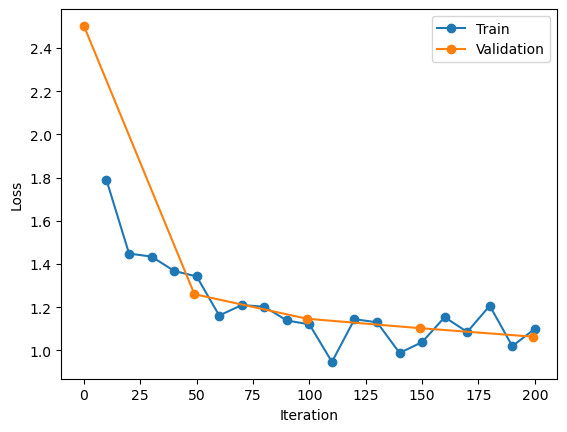

In [15]:
train_its, train_losses = zip(*metrics.train_losses)
validation_its, validation_losses = zip(*metrics.val_losses)
plt.plot(train_its, train_losses, "-o", label="Train")
plt.plot(validation_its, validation_losses, "-o", label="Validation")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
model_lora, _ = load(model_path, adapter_path=adapter_path)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
response = generate(model_lora, tokenizer, prompt=prompt, verbose=True)

SQL is a table-based, row-oriented, and table-oriented language used for managing and manipulating databases. It is not used for querying the background color of geographical locations such as the Australian Capital Territory (ACT). The background color of the ACT is determined by the physical location of the screen, not by a database. If you have a database with the background color as a field, you could use SQL to select the background color of the ACT, but the ACT itself does not have a background color in the sense that a screen or a web page does.
Prompt: 18 tokens, 157.168 tokens-per-sec
Generation: 119 tokens, 52.161 tokens-per-sec
Peak memory: 8.265 GB


In [19]:
# Load the fine-tuned model
model_enhanced, _ = load(model_path, adapter_path=adapter_path)

# Test with a sample prompt
test_prompts = [
    "you are SQL translator and translate Natural Language to SQL.Now Translate:What is best city in the world?",
    "you are SQL translator and translate Natural Language to SQL.how many engines we have in system is gas powered and how many is CNG?",
    "you are SQL developer and express answers in SQL.What is the max gross weight of the Robinson R-22?"
]

for prompt in test_prompts:
    print(f"\nPrompt: {prompt}")
    print("-" * 50)

    if tokenizer.chat_template is not None:
#        messages = [{"role": "system", "content": "you are SQL developer and express answers in SQL only."},{"role": "user", "content": prompt}]
        messages = [{"role": "user", "content": prompt}]
        formatted_prompt = tokenizer.apply_chat_template(
            messages, add_generation_prompt=True
        )
    else:
        formatted_prompt = prompt

    response = generate(
        model_enhanced,
        tokenizer,
        prompt=formatted_prompt,
        max_tokens=100,
        verbose=False
    )
    print(response)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]


Prompt: you are SQL translator and translate Natural Language to SQL.Now Translate:What is best city in the world?
--------------------------------------------------
SELECT City FROM WorldCities WHERE Best = 'Yes'

Prompt: you are SQL translator and translate Natural Language to SQL.how many engines we have in system is gas powered and how many is CNG?
--------------------------------------------------
To answer your question, we need to select the number of engines from the system where the fuel is either gas or CNG. Here's the SQL query for that:

```
SELECT COUNT EngineID FROM Engines WHERE Fuel = 'Gas' OR Fuel = 'CNG'

Prompt: you are SQL developer and express answers in SQL.What is the max gross weight of the Robinson R-22?
--------------------------------------------------
To answer your table-free question, I'm assuming that you have a table with aircraft information. Let's say the table is called aircraft_info, and the gross weight is stored in the column 'gross_weight'.

SELE